# 1. 安装依赖库

In [37]:
""" %pip install torchdeq """

' %pip install torchdeq '

# 2. 导入必要的库

In [38]:
import torch
from torchdeq import get_deq
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# 3. 定义自定义模型

In [ ]:
from Block import Block
import types
args=types.SimpleNamespace()
args.n_embd = 4
args.head_size=2
B, T, C = 1, 1, args.n_embd
max_iter=12
f_tol=1e-6

block = Block(args)

# 定义均衡函数
def f(z):return block(z)#+z

# 获取 DEQ 层
deq = get_deq(f_solver="broyden", f_max_iter=max_iter, f_tol=f_tol)

# 4. 初始化变量并求解固定点

In [40]:
# 初始化固定点求解的初始值
z0 = torch.randn(B,T,C)

# 使用 DEQ 层求解固定点
z_out, info = deq(f, z0)

# 获取求解得到的固定点
fixed_point = z_out[-1]

#如果固定点里有nan，终止程序
if torch.isnan(fixed_point).any():
    raise Exception("求解过程中出现NaN，终止程序")

# 打印固定点
print(f"求解得到的固定点: {fixed_point}")

# 打印求解过程中的绝对误差轨迹
abs_trace = info['abs_trace'].mean(dim=0)[1:]
print(f"绝对误差轨迹: {abs_trace}")

求解得到的固定点: tensor([[[-1.0216, -0.8654,  0.4816,  1.4055]]],
       grad_fn=<NativeLayerNormBackward0>)
绝对误差轨迹: tensor([ 0.3279,  0.1477,  0.1139,  0.2630, 19.0968,  0.2852,  0.1654,  0.1478,
         0.2962,  0.1347,  0.1269,  0.3146])


# 5. 可视化固定点收敛过程

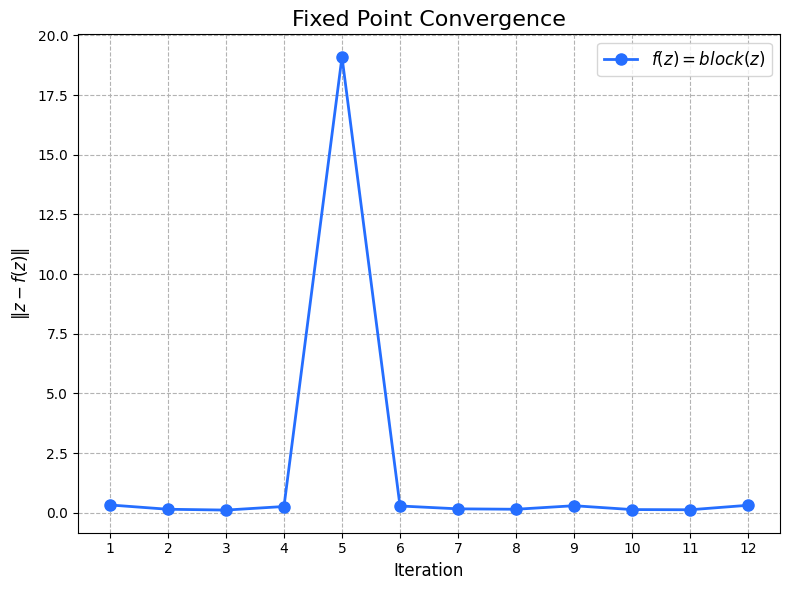

In [41]:
# 迭代次数
iterations = np.arange(len(abs_trace)) + 1

# 创建一个图形窗口
plt.figure(figsize=(8, 6))

# 绘制收敛曲线
plt.plot(iterations, abs_trace, 'o-', color="#256eff", markersize=8, linewidth=2, label='$f(z) = block(z)$')

# 添加网格线
plt.grid(True, which="both", ls="--", c='0.7')

# 添加坐标轴标签
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('$\\|z - f(z)\\|$', fontsize=12)

# 设置 x 轴刻度
plt.xticks(iterations)

# 添加标题
plt.title('Fixed Point Convergence', fontsize=16)

# 添加图例
plt.legend(loc='best', fontsize=12)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 6. 定义损失函数并进行反向传播

In [42]:
# 定义目标值
linear= nn.Linear(C,C)
linear.requires_grad_(False)
target = linear(z0)


# 获取支持隐式微分的 DEQ 层
deq = get_deq(
    ift=True,#True为开启训练
    f_solver= 'broyden', f_max_iter=max_iter, f_tol=f_tol,
    b_solver='broyden', b_max_iter=max_iter, b_tol=f_tol
)



""" # 使用 DEQ 层求解固定点
z_out, info = deq(f, z0)

# 获取求解得到的固定点
fixed_point = z_out[-1]

# 计算损失
loss = (fixed_point - target).abs().mean()

# 反向传播
loss.backward()

# 打印损失和参数的梯度
print(f"损失: {loss.item()}") """

' # 使用 DEQ 层求解固定点\nz_out, info = deq(f, z0)\n\n# 获取求解得到的固定点\nfixed_point = z_out[-1]\n\n# 计算损失\nloss = (fixed_point - target).abs().mean()\n\n# 反向传播\nloss.backward()\n\n# 打印损失和参数的梯度\nprint(f"损失: {loss.item()}") '

# 7. 定义优化器并执行重复训练

In [43]:

# 定义优化器，训练
optimizer = torch.optim.RMSprop(block.parameters(), lr=1e-3)


# 训练参数
epochs = 1000  # 训练轮数
loss_history = []  # 存储每轮的损失值
# 训练循环
for epoch in range(epochs):
    # 重置梯度
    optimizer.zero_grad()

    # 求解固定点
    z_out, info = deq(f, z0)
    fixed_point = z_out[-1]
    
    # 计算损失
    loss = (fixed_point - target).abs().mean()
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    
    # 记录历史
    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 打印最终结果
print(f"\n训练完成! ")
print(f"最终固定点: {fixed_point}")
print(f"目标值: {target}")

Epoch [1/1000], Loss: 1.0867
Epoch [11/1000], Loss: 0.8563
Epoch [21/1000], Loss: 0.7926
Epoch [31/1000], Loss: 0.7866
Epoch [41/1000], Loss: 0.7280
Epoch [51/1000], Loss: 0.6635
Epoch [61/1000], Loss: 0.6401
Epoch [71/1000], Loss: 0.6262
Epoch [81/1000], Loss: 0.6094
Epoch [91/1000], Loss: 0.5858
Epoch [101/1000], Loss: 0.5930
Epoch [111/1000], Loss: 0.5558
Epoch [121/1000], Loss: 0.5467
Epoch [131/1000], Loss: 0.5354
Epoch [141/1000], Loss: 0.5269
Epoch [151/1000], Loss: 0.5319
Epoch [161/1000], Loss: 0.5219
Epoch [171/1000], Loss: 0.5203
Epoch [181/1000], Loss: 0.5116
Epoch [191/1000], Loss: 0.5170
Epoch [201/1000], Loss: 0.5034
Epoch [211/1000], Loss: 0.5005
Epoch [221/1000], Loss: 0.4985
Epoch [231/1000], Loss: 0.4917
Epoch [241/1000], Loss: 0.4937
Epoch [251/1000], Loss: 0.4870
Epoch [261/1000], Loss: 0.4798
Epoch [271/1000], Loss: 0.4767
Epoch [281/1000], Loss: 0.4728
Epoch [291/1000], Loss: 0.4661
Epoch [301/1000], Loss: 0.5036
Epoch [311/1000], Loss: 0.4595
Epoch [321/1000], L

# 8. 可视化训练过程

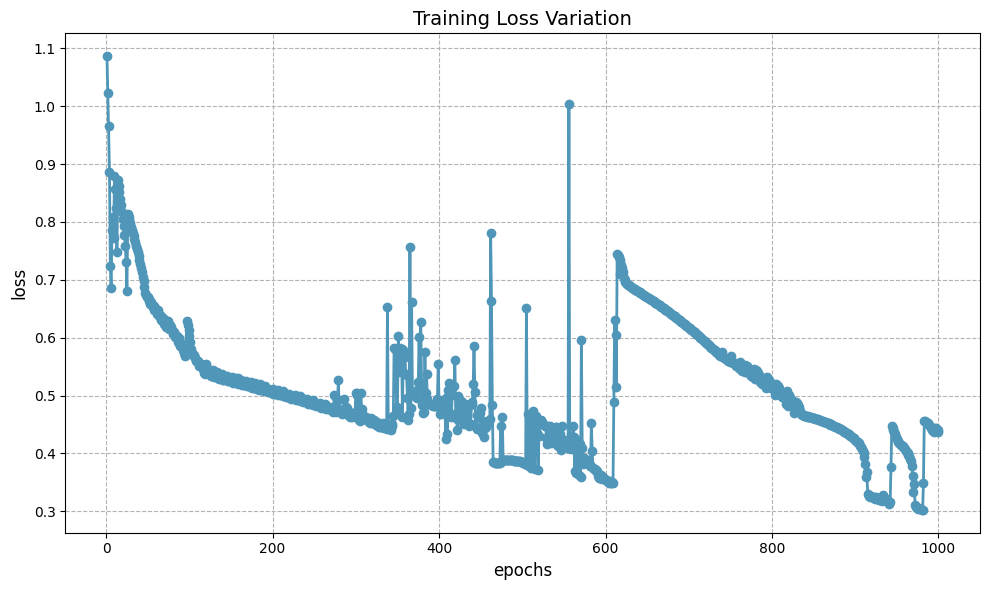

In [44]:
# 创建一个图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制损失变化曲线
ax.plot(range(1, epochs+1), loss_history, 'o-', color='#4f96b8', linewidth=2)
ax.set_title('Training Loss Variation', fontsize=14)
ax.set_xlabel('epochs', fontsize=12)
ax.set_ylabel('loss', fontsize=12)
ax.grid(True, which="both", ls="--", c='0.7')

plt.tight_layout()
plt.show()

# 9. 验证训练结果

In [45]:
deq = get_deq(f_solver='broyden', f_max_iter=max_iter, f_tol=f_tol)
z_out, info = deq(f, z0)
fixed_point = z_out[-1]

print(f"\n验证结果:")
print(f"训练后模型的固定点: {fixed_point}")
print(f"目标值: {target}")
print(f"误差: {abs(fixed_point - target)}")


验证结果:
训练后模型的固定点: tensor([[[-0.3182, -0.4710, -0.4295,  0.8163]]],
       grad_fn=<NativeLayerNormBackward0>)
目标值: tensor([[[-0.3172,  0.3284, -0.4375, -0.1238]]])
误差: tensor([[[9.1326e-04, 7.9935e-01, 8.0311e-03, 9.4017e-01]]],
       grad_fn=<AbsBackward0>)
